# Willoughby (2006) profile fit on SAR data
The SAR data grid is already centered on the TC center found by the method of Léo.

Note that the Willoughby profile used here doesn't include the sum of 2 exponentials as a possible solution.

However, the polynomial ramp smoothing is included. As in the paper, we fit the profile without smoothing first, then choose for an arbitrary transition width, and then derive R1 using equation (3) of the paper. Indeed, we have 2 unknowns $ R1 $ and $ R2 $, but if we set the transition width then we have only 1 unknown, that is fully determined by the condition that $ \frac{dV}{dr} = 0 $ at $ r = Rmax $ (equation 3 of the paper). We then print the smoothed profile.


In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import griddata
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

import functions as f

In [2]:
### PATHS
# dir_path  = '/home/arthur/data/cyclobs/ggd/'
dir_path  = '/home/arthur/data/cyclobs/rotated_files/'
# file_path = 's1b-iw-owi-cm-20170923t104349-20170923t104554-000003-00D45F_ll_gd_rotated.nc'
# file_path = 'rs2--owi-cm-20120928t095127-20120928t095327-00003-BDBE0_ll_gd_rotated.nc'
# NAN BUG (because no wind speed value after r = 400 km, we have to stop the dataset there) file_path = 'rs2--owi-cm-20130701t104119-20130701t104235-00003-79BFE_ll_gd_rotated.nc'
# file_path = 's1a-ew-owi-cm-20180201t132219-20180201t132527-000003-022E2F_ll_gd_rotated.nc'

# Compare with Alexis'
# file_path = 's1a-ew-owi-cm-20180808t041303-20180808t041507-000003-0283BF_ll_gd_rotated.nc' # 2
# file_path = 's1a-ew-owi-cm-20180807t154302-20180807t154506-000003-028386_ll_gd_rotated.nc' # 3
# file_path = 's1a-ew-owi-cm-20180818t150300-20180818t150604-000003-0288C3_ll_gd_rotated.nc' # 4
# file_path = 's1a-ew-owi-cm-20180819t032959-20180819t033303-000003-0288F7_ll_gd_rotated.nc' # 5
# file_path = 's1a-ew-owi-cm-20190731t034721-20190731t034910-000003-033442_ll_gd_rotated.nc' # 6
# file_path = 's1b-ew-owi-cm-20180810t165606-20180810t165822-000003-0167B7_ll_gd_rotated.nc' # 7

# LANE
file_path = 's1a-ew-owi-cm-20180818t150300-20180818t150604-000003-0288C3_ll_gd_rotated.nc'

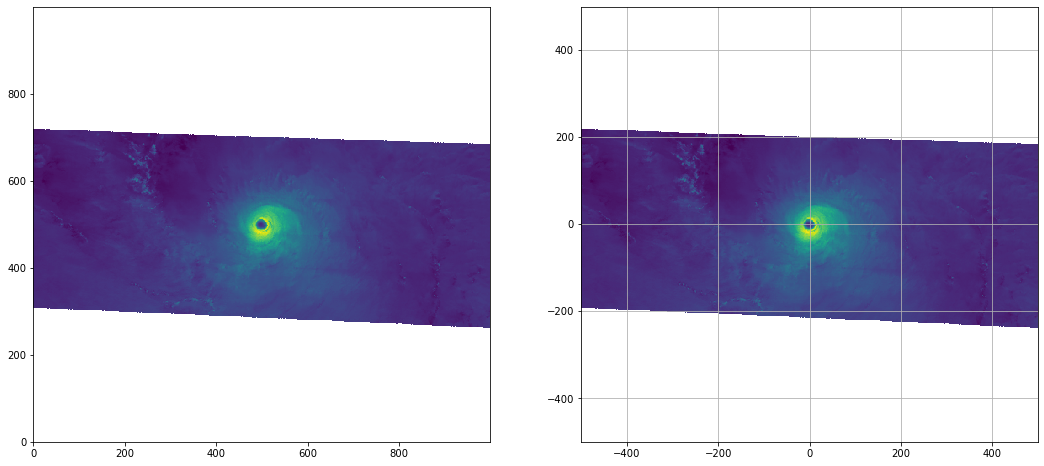

In [3]:
### OPEN AND PRINT
ds = xr.open_dataset(dir_path + file_path)
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.pcolormesh(ds['x'], ds['y'], ds['wind_speed'])
plt.subplot(1, 2, 2)
plt.pcolormesh(ds['x_coords'], ds['y_coords'], ds['wind_speed']);plt.grid()

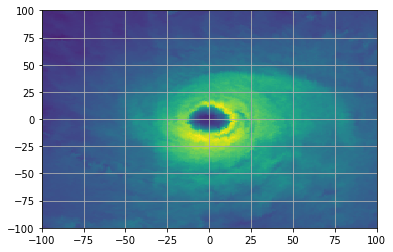

In [4]:
### TEST
# plt.pcolormesh(ds['x'], ds['y'], ds['wind_speed'])
plt.pcolormesh(ds['x_coords'], ds['y_coords'], ds['wind_speed'])
plt.axis([-100,100,-100,100]);plt.grid()

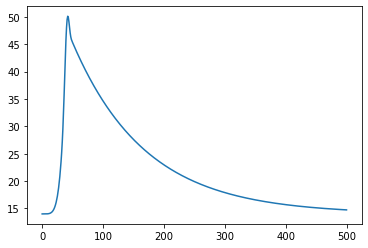

In [5]:
### DEFINE PROFILE FUNCTION
# ======> This function will be used for the fitting (no polynomial ramp smoothing here)
def willoughby_profile(r, n, X1, Vmin, Rmax, Vmax):
    '''We assume V(0) = Vmin != 0 to fit SAR data'''
    V    = r * 0.
    Vinf = (Vmax - Vmin) * ((r / Rmax) ** n) + Vmin
    Vsup = (Vmax - Vmin) * np.exp((-1.) * ((r - Rmax) / X1)) + Vmin
    V[r <=Rmax] = Vinf[r <=Rmax]
    V[r > Rmax] = Vsup[r > Rmax]
    return V

# ======> These functions will be used for the plotting (we use polynomial ramp smoothing here)
def willoughby_inner_profile(r, n, Vmin, Rmax, Vmax):
    Vi = (Vmax - Vmin) * ((r / Rmax) ** n) + Vmin
    return Vi

def polyn_ramp(xi):
    w = (126 * xi ** 5) - (420 * xi ** 6)  + (540 * xi ** 7) - (315 * xi ** 8) + (70 * xi ** 9)
    return w

def willoughby_polyn_ramp(r, Vi, Vo, R1, R2):
    '''CHECK: OK'''
    xi               = (r - R1) / (R2 - R1)
    w                = r * 0. # Default value if xi <= 0
    xi_over_one      = (xi >= 1)
    w[xi_over_one]   = 1.
    xi_in_between    = (xi > 0) & (xi < 1)
    w[xi_in_between] = polyn_ramp(xi[xi_in_between])
    V                = np.multiply(Vi, 1 - w) + np.multiply(Vo, w)
    return V

def willoughby_outer_profile(r, n, X1, Vmin, Rmax, Vmax):
    Vo = (Vmax - Vmin) * np.exp((-1.) * ((r - Rmax) / X1)) + Vmin
    return Vo

def willoughby_profile_complete(r, n, X1, Vmin, Rmax, Vmax, R1, R2):
    V              = r * 0. # initialize
    Vi             = willoughby_inner_profile(r, n, Vmin, Rmax, Vmax)
    Vo             = willoughby_outer_profile(r, n, X1, Vmin, Rmax, Vmax)
    Vtrans         = willoughby_polyn_ramp(r, Vi, Vo, R1, R2)
    r_under_R1     = (r <= R1)
    r_in_between   = (r > R1) & (r < R2)
    r_over_R2      = (r >= R2)
    V[r_under_R1]  = Vi[r_under_R1]
    V[r_in_between]= Vtrans[r_in_between]
    V[r_over_R2]   = Vo[r_over_R2]
    return V

def equation_3(R1, *args):
    '''args = n, X1, Rmax, trans_width'''
    n, X1, Rmax, trans_width = args # automatic unpacking
    xi_max     = (Rmax - R1) / trans_width
    left_side  = polyn_ramp(xi_max)
    right_side = (n * X1) / ((n * X1) + Rmax)
    return left_side - right_side
    
# Print the shape
r = np.arange(501)
V = willoughby_profile_complete(r, n=5, X1=3*40, Vmin=14, Rmax=40, Vmax=48, R1=30, R2=50) # first, width of transition R2 - R1 is set a priori to 20km
plt.plot(r, V)   

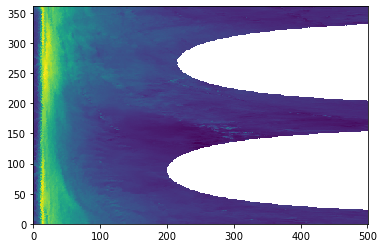

In [6]:
### DEFINE (r, theta) GRID
r     = np.arange(501)
th    = np.arange(361)
r, th = np.meshgrid(r, th)
ds_r  = np.array(ds['r_polar'])

ds_th = np.mod(np.array(ds['theta']) * 180. / np.pi, 360) # convert theta from radians to degrees
ds_ws = np.array(ds['wind_speed'])
# Possible to call griddata() without using meshgrid() before? 
spd   = griddata((ds_r.flatten(), ds_th.flatten()), ds_ws.flatten(), (r, th), method='nearest')

plt.pcolormesh(spd)

Initialization values ==> 1 ,  45 ,  7.24 ,  15 ,  55.93
Final values ========> [ 2.46 53.11  8.33 13.43 55.14]
estimated R1: [5.]
result of equation with est. R1: [-0.97493724]


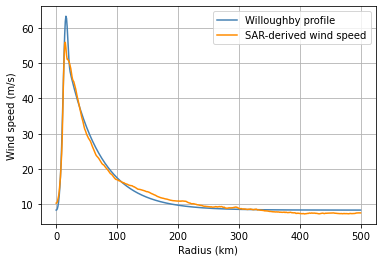

In [7]:
### FITTING THE PROFILE
# Initializing the values
radius      = np.arange(501) + .0001 # to avoid having both r = 0 and n < 0 during fitting process
spdm        = np.nanmean(spd, axis=0)
n           = 1
Rmax        = np.nanargmax(spdm) # 40
X1          = 3 * Rmax
Vmin        = np.nanmin(spdm) # 14
Vmax        = np.nanmax(spdm) # 48
trans_width = 20 # We set the transition zone a priori at a value between 10 and 25 km. Here we choose R2 - R1 = 20km

# Fit profile to data
print("Initialization values ==>", n, ", ", X1, ", ", "{:.2f}".format(Vmin), ", ", Rmax, ", ", "{:.2f}".format(Vmax))
popt, pcov = curve_fit(willoughby_profile, radius, spdm, [n, X1, Vmin, Rmax, Vmax])
print("Final values ========>", np.around(popt, 2))

# Determine transition zone
args        = (popt[0], popt[1], popt[3] - 10, trans_width) # n, X1, Rmax, trans_width
estimated_R1= fsolve(equation_3, Rmax - 10, args=args)
print("estimated R1:", estimated_R1)
print("result of equation with est. R1:", equation_3(estimated_R1, *args))
# R1    = popt[3] - 10 if fsolve() doesn't work ==> use Rmax -10 and Rmax + 10:
R1    = estimated_R1
R2    = R1 + trans_width
# V_fit = willoughby_profile(radius, popt[0], popt[1], popt[2], popt[3], popt[4]) # old profile
V_fit = willoughby_profile_complete(radius, popt[0], popt[1], popt[2], popt[3], popt[4], R1, R2)

# Print the results
fig1  = plt.plot(radius, V_fit, color='steelblue', label='Willoughby profile')      # V_fit
fig2  = plt.plot(radius, spdm,  color='darkorange',  label='SAR-derived wind speed')  # V_obs
plt.xlabel('Radius (km)')
plt.ylabel('Wind speed (m/s)')
plt.legend();plt.grid()

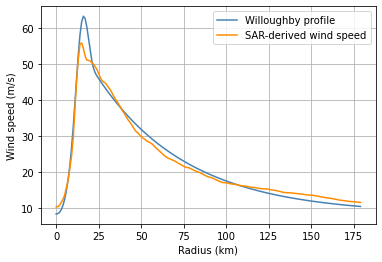

In [8]:
### SMALLER SCALE
fig1 = plt.plot(radius[:180], V_fit[:180], color='steelblue', label='Willoughby profile')         # V_fit
fig2 = plt.plot(radius[:180], spdm[:180],   color='darkorange',  label='SAR-derived wind speed')  # V_obs
plt.xlabel('Radius (km)')
plt.ylabel('Wind speed (m/s)')
plt.legend();plt.grid()
# plt.savefig('profil.png')
plt.show()

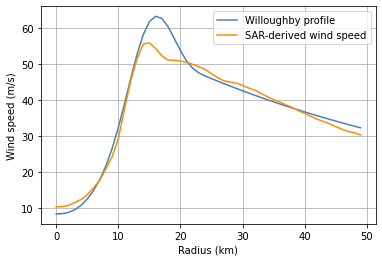

In [9]:
### EVEN SMALLER SCALE
fig1 = plt.plot(radius[:50], V_fit[:50], color='steelblue', label='Willoughby profile')         # V_fit
fig2 = plt.plot(radius[:50], spdm[:50],   color='darkorange',  label='SAR-derived wind speed')  # V_obs
plt.xlabel('Radius (km)')
plt.ylabel('Wind speed (m/s)')
plt.legend();plt.grid()
# plt.savefig('profil.png')
plt.show()

In [10]:
### TODO
# Willoughby: use polynomial ramp and refine the location of merging point? 2 exponentials sum? 
# Holland: Initialize pn and pc a better way? 
# Chavas: put Vmin directly into the equation?
# Rankine: define alpha and omega? 
# Own: take the log of all obs and find what it looks like
# Statistical aspects (Holland B parameters sensitivity)
# Initialization of the parameters?